# Candle Reviews

My mother loves candles, especially during the holiday season. During the cold December evenings she’ll have so many lit up that the whole house smells like an amalgam of cedarwood, snickerdoodles, vanilla bean, and whatever else she has stored away in her holiday candle collection.  

This got me wondering if my mom alone was just a christmas candle enthusiast, or if this was part of a wider holiday phenomenon. I decided that the best way to answer my question was to look at the candle reviews of the best selling candle on amazon. This led to a quick google search which turned into a much longer google search, into a full mini project that probably expanded past the requirements for this assignment. 

In my research I found that amazon’s best selling candle was [Yankee Candle’s Balsam & Cedar](https://www.yankeecandle.com/product/balsam--cedar/_/R-1062314) and using the [Amazon Product/Reviews/Keywords API](https://rapidapi.com/logicbuilder/api/amazon-product-reviews-keywords) on RapidAPI I managed to collect the amazon reviews from the last 20 days (roughly Dec 8th - Dec 28th)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# setting up plot stuff

# figure size
from matplotlib import rcParams
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 200

# datetime axis 
import matplotlib.dates as mdates
daily = mdates.DateFormatter('%d')

# setting up color palette
c1 = '#A0CB9F'
c2 = '#7CAB7E'
c3 = '#4D8D55'
c4 = '#477D4C'
c5 = '#3D6C41'

In [3]:
# load reviews
reviews = pd.read_csv('Candle_Reviews.csv')

# drop Unnamed: 0 and set the date as a dateime object as the index
reviews['date'] = pd.DataFrame(pd.to_datetime(reviews['date']))
reviews = reviews.drop(columns = 'Unnamed: 0').set_index('date')

reviews.head()

,id,name,rating,review,review_data,title,verified_purchase
date,,,,,,,
2020-12-27,R2888VRD3XQF88,James McPartland,5.0,Whole room smelled like a Christmas tree. Stil...,"Reviewed in the United States on December 27, ...",Best Christmas Candle,1.0
2020-12-27,RXI4NIYNWN1KX,Marilyn R,5.0,The scent is fabulous!,"Reviewed in the United States on December 27, ...",Great smell!,1.0
2020-12-27,R1GHKV8OH9YRBA,Emerald,5.0,Arrived very quickly and filled our home with ...,"Reviewed in the United States on December 27, ...",Long lasting scent,1.0
2020-12-27,RO9W9K9HGV5F5,Analog Guy,5.0,As advertised. Very well packed. I had to trim...,"Reviewed in the United States on December 27, ...",Very nice product.,1.0
2020-12-27,RTC07ZN7IS1ZB,Amazon Customer,2.0,Scent was barely there and does not lasts long,"Reviewed in the United States on December 27, ...",Not worth it,1.0


## Reviews Over Time

Now that I had my data,  my first mission was to find how many reviews were made each day.

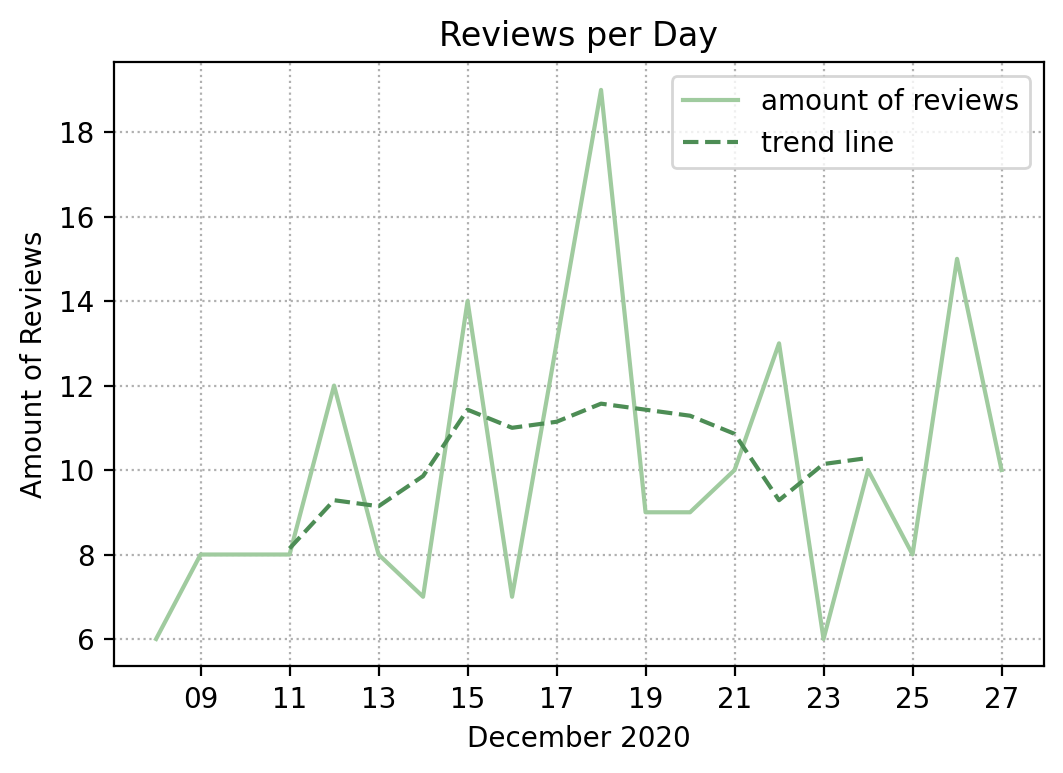

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# resamples such that we can see the amount of reviews in a day
daily_reviews = reviews['rating'].resample('d').count()

# create a trend line to see the change a little more clearly
decomp = seasonal_decompose(daily_reviews)
trend = decomp.trend.dropna()

# plot lines
ax = plt.subplot()
ax.plot(daily_reviews,label='amount of reviews',c=c1)
ax.plot(trend,label='trend line',c=c3,linestyle='--')
ax.grid(linestyle='dotted')

ax.xaxis.set_major_formatter(daily)
ax.legend()
plt.ylabel('Amount of Reviews')
plt.xlabel('December 2020')
plt.title('Reviews per Day');

Well there does to seem to be a lot of review activity and, while my data was quite limited in terms of timescale, it did appear that there was a growth in the amount of reviews during mid December. To further confirm this, I plotted a trend line as well which showed the same results.

On an interesting note: the two days with the highest reviews were Dec 18th, `the last day of Hanukkah` and Dec 26, `the day after Christmas`. Altogether, it appeared that Balsam & Cedar is quite popular with the holiday crowd!

## Ratings

Next I wanted to take a looks at the ratings, begining with a pie chart to visualize the distribution. 

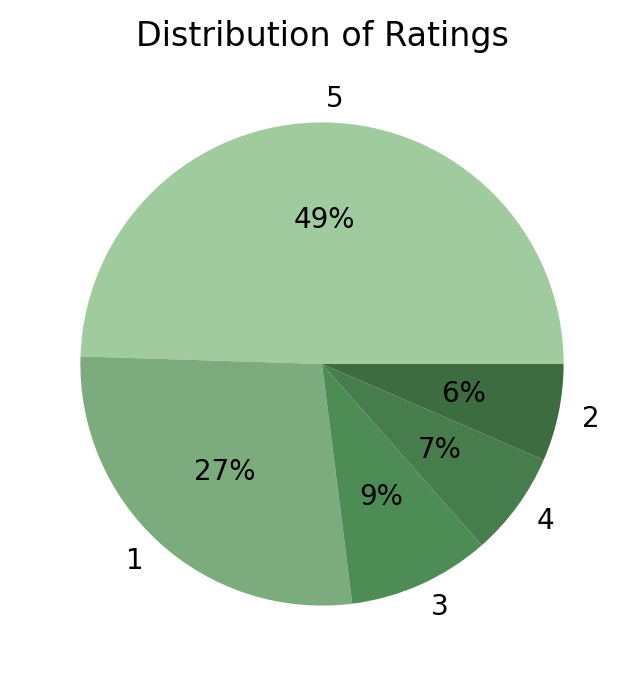

In [5]:
# Select the ratings and make a dataframe of the value counts
rating = reviews['rating'].astype('int')
rate_count = pd.DataFrame(rating.value_counts())

# plot
plt.pie(rate_count.rating,labels=rate_count.index,autopct='%d%%',colors=[c1,c2,c3,c4,c5])
plt.title('Distribution of Ratings');

As you can see, ratings appeared very polarized. More than 75% of the ratings are either a full five stars or a meager one. Lucky for Yankee Candle, the large majority of these ratings were five stars!

How were these ratings distributed by day? Since most ratings were either 1 or 5, I decieded to focus on these particular ratings. 

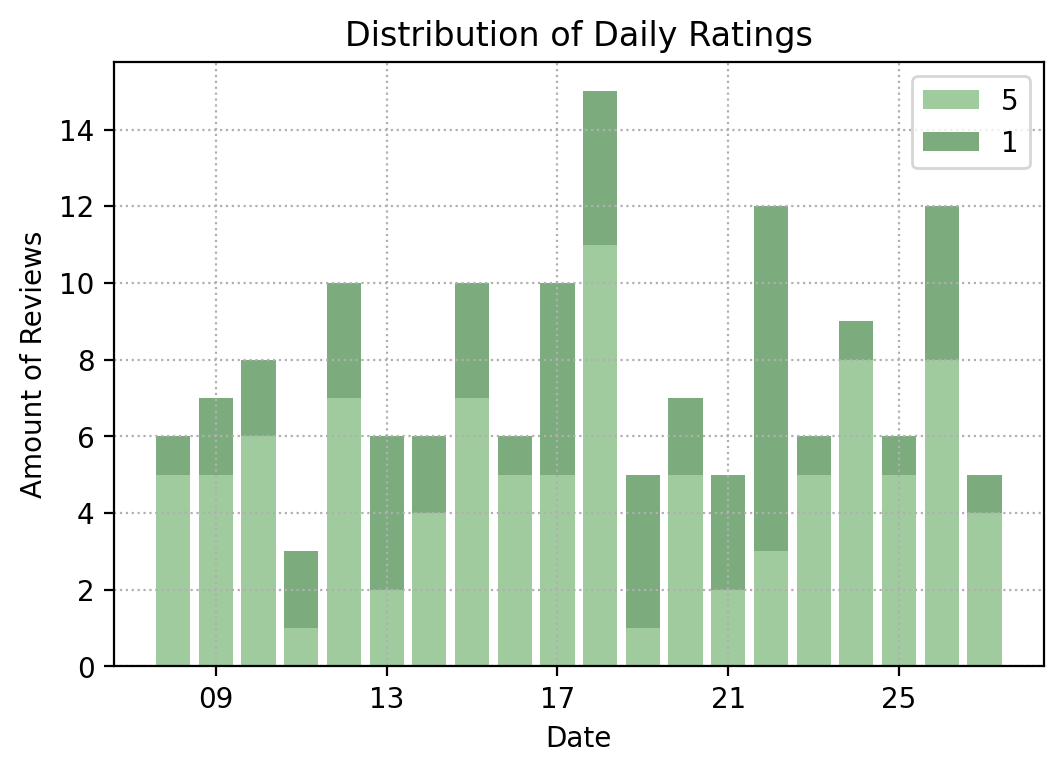

In [6]:
# create an empty dataframe
bar_data=pd.DataFrame()

# independantly resamples by day and put the counts in the empty data frame
for i in [1,5]:
    bar_data[str(i)] = rating[rating==i].resample('d').count()
bar_data = bar_data.fillna(0)

# plot!
ax = plt.subplot()
bottom = np.zeros(len(bar_data))
for col,color in [(5,c1),(1,c2)]:
    plt.bar(bar_data.index,bar_data[str(col)].values,bottom=bottom,label=str(col),color=color)
    bottom += bar_data[str(col)].values
ax.grid(linestyle='dotted')
ax.xaxis.set_major_formatter(daily)
ax.legend()
plt.ylabel('Amount of Reviews')
plt.xlabel('Date')
plt.title('Distribution of Daily Ratings')
plt.legend();

Seems the most positive ratings were once again made on the 18th as well as the 24th and 26th. Seems like a lot of people are enjoying their candles during the holidays!

On the other hand, the most negative ratings were made on the 22nd. I did a bit of snooping but this particular day didn’t seem to stick out in terms of candle related events.

## Candle Reviews

Well what if this was all a funny coincidence? What if people sporadically make candle reviews and they just so happen fall near winter holidays? Just to make sure, I decided to take a look at the contents of the reviews, putting all the words into a word cloud to see what were the most common words. 

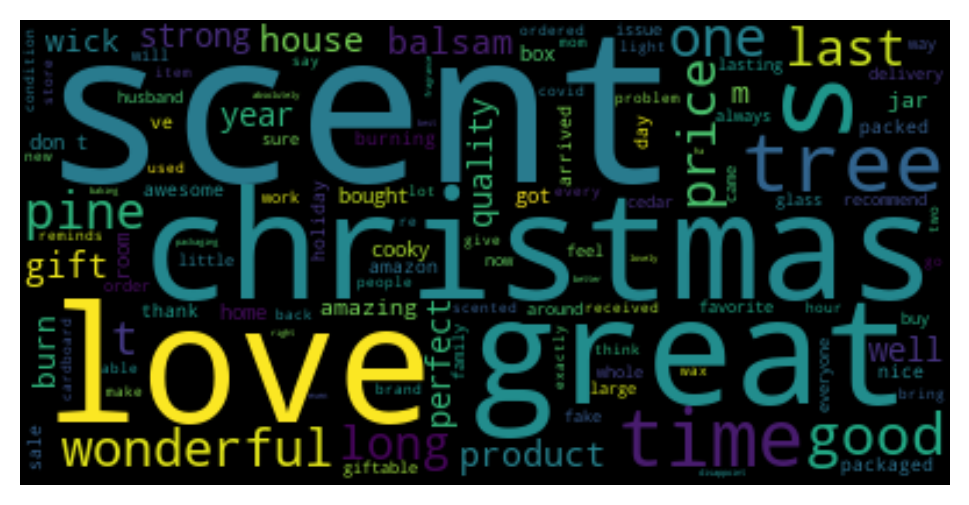

In [7]:
import wordcloud as wc
import string
from nltk.stem import WordNetLemmatizer 

# make all text lowercase and strip any unnecessary punctuation.
reviews['review'] = reviews['review'].str.lower()
reviews['review'] = reviews['review'].str.replace('[{}]'.format(string.punctuation),' ')

# put all the text from the 5 star reviews into the variable text
text = " ".join(val for val in reviews[reviews['rating']==5]['review'])

# Lemmatization
lemmatizer = WordNetLemmatizer() 
lem_text = [lemmatizer.lemmatize(word) for word in text.split(' ')]
text = ' '.join([str(word) for word in lem_text]) 

#Create stopword list includein the words 'candle' and the brand 'Yankee candle'
stopwords = set(wc.STOPWORDS)
stopwords.update(["candle", "yankee candle",'yankee','smell','wa'])

# Create and generate a word cloud image:
wordcloud = wc.WordCloud(stopwords=stopwords).generate(text)

# show the image
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Of all the words in all the five star reviews, 'Christmas' appears to be one of the most common, proving (at least to me) that these reviews are indeed related to the winter holidays, or at least Christmas in particular. (It’s also worth noting that the words 'gift' and 'giftable' also show up, so it would appear that candles could be a common christmas gift as well.)

## Conclusions 

In all, the amount of reviews, particularly those of 5 star ratings, spiked near both the last day of Hanukkah as well as the days bordering Christmas. It also appeared that the contents of the reviews implied that much of the satisfaction these candles brought were enhanced by the holiday season. Overall, these findings suggest that my mother is indeed not a crazy Christmas candle collector, but instead part of a much larger holiday candle craze. 